# Fault Tolerance in Workflow Execution

In [2]:
from langgraph.graph import StateGraph , START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

### Define State

In [3]:
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str
    step3: str

### Define Steps

In [4]:
def step_1(state: CrashState) -> CrashState:
    print("Executing Step 1")
    return {
        "step1": "Step 1 completed",
        "input": state["input"]
    }

def step_2(state: CrashState) -> CrashState:
    print("Executing Step 2....now manually interupt from the notebook toolbar (Stop) to simulate a crash")
    time.sleep(30)  # Wait to allow manual interruption
    return{
        "step2": "Step 2 completed"
    }

def step_3(state: CrashState) -> CrashState:
    print("Executing Step 3")
    return {
        "step3": "Step 3 completed"
    }

### Create Workflow

In [5]:
graph = StateGraph(CrashState)

graph.add_node("step_1", step_1)
graph.add_node("step_2", step_2)
graph.add_node("step_3", step_3)

graph.add_edge(START, "step_1")
graph.add_edge("step_1", "step_2")
graph.add_edge("step_2", "step_3")
graph.add_edge("step_3", END)


checkpointer  = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

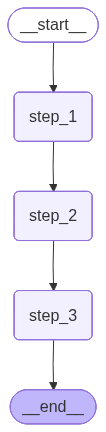

In [6]:
workflow

### Define Initial State

In [7]:
initial_state = {
    "input": "start"
}

### Configure Thread ID

In [8]:
config = {
    "configurable":{
        "thread_id": "thread-1"
    }
}

### Simulating Fault Tolerance by Manual Interruption

To demonstrate fault tolerance, manually interrupt the workflow during Step 2 using the notebook's stop button. This simulates a crash scenario, allowing us to observe how the workflow handles interruptions and resumes execution.

In [9]:
try:
  print("Running workflow: Manully interrupt during step 2....")
  workflow.invoke(initial_state, config = config)
except KeyboardInterrupt:
  print("Workflow manually interrupted (crash simulated)")

Running workflow: Manully interrupt during step 2....
Executing Step 1
Executing Step 2....now manually interupt from the notebook toolbar (Stop) to simulate a crash
Workflow manually interrupted (crash simulated)


### Observing Workflow Progress and Interruption

After running the workflow, we can see that only Step 1 has completed successfully. Step 2 was interrupted, simulating a crash scenario.

In [11]:
workflow.get_state(config)

StateSnapshot(values={'input': 'start', 'step1': 'Step 1 completed'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b313c-3f27-6b51-8001-3afb2a1bb206'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-27T09:03:12.168394+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b313c-3f21-6f09-8000-b62368a4ad49'}}, tasks=(PregelTask(id='f94381f4-47e9-99a3-72a1-6fdaabdf3282', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

### View the Complete State History

Below, we can review the entire history of workflow states, showing progress and interruptions throughout execution.

In [12]:
list(workflow.get_state_history(config))

[StateSnapshot(values={'input': 'start', 'step1': 'Step 1 completed'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b313c-3f27-6b51-8001-3afb2a1bb206'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-27T09:03:12.168394+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b313c-3f21-6f09-8000-b62368a4ad49'}}, tasks=(PregelTask(id='f94381f4-47e9-99a3-72a1-6fdaabdf3282', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b313c-3f21-6f09-8000-b62368a4ad49'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T09:03:12.166030+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_

### Re-running the workflow from step 2

By passing `None` instead of `initial_state`, the workflow resumes from the point where it was interrupted. This demonstrates fault tolerance, allowing execution to continue from the last completed step.

In [13]:
final_state = workflow.invoke(None, config = config)

Executing Step 2....now manually interupt from the notebook toolbar (Stop) to simulate a crash
Executing Step 3


In [14]:
print("Final State:", final_state)

Final State: {'input': 'start', 'step1': 'Step 1 completed', 'step2': 'Step 2 completed', 'step3': 'Step 3 completed'}


In [16]:
workflow.get_state(config)

StateSnapshot(values={'input': 'start', 'step1': 'Step 1 completed', 'step2': 'Step 2 completed', 'step3': 'Step 3 completed'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3143-cdc1-6941-8003-54d1f22da247'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-10-27T09:06:35.026030+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3143-cdbe-6fb2-8002-41ee2984b1e1'}}, tasks=(), interrupts=())

In [17]:
list(workflow.get_state_history(config))

[StateSnapshot(values={'input': 'start', 'step1': 'Step 1 completed', 'step2': 'Step 2 completed', 'step3': 'Step 3 completed'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3143-cdc1-6941-8003-54d1f22da247'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-10-27T09:06:35.026030+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3143-cdbe-6fb2-8002-41ee2984b1e1'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'Step 1 completed', 'step2': 'Step 2 completed'}, next=('step_3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b3143-cdbe-6fb2-8002-41ee2984b1e1'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-10-27T09:06:35.024954+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b313c-3f27-6b51-80